# 1.0 Introduction
Welcome to the next installment in our series of notebooks dedicated to the Machine Learning component of our project.  
<br>
This notebook focuses on **Tree-Based models**, which are robust algorithms widely used in machine learning. Our primary objective is to thoroughly explore and **evaluate the performance of these models** using cross-validation techniques. To optimize their performance, we will employ **Optuna to fine-tune each model's parameters**. Additionally, we will calculate feature importances for the best-performing models, shedding light on which features contribute most significantly to their predictive power.  
<br>

### Models Covered
In this notebook, we will analyze the following Tree-Based models:

* Decision Tree
* Random Forest
* Extra Trees  

Each model will undergo rigorous evaluation through cross-validation to assess their metrics and overall performance.

In [1]:
import pandas as pd
import numpy as np
import optuna as opt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from optuna.pruners import BasePruner
import matplotlib.pyplot as plt

In [2]:
import import_ipynb
from ML01_Baseline import (
    TFToBinaryTransformer,
    FeatureEngineering,
    UpdateColumnTransformer,
    X_train,
    y_train
)

importing Jupyter notebook from ML01_Baseline.ipynb
Baseline Average MAE: 119.67833952398125
Baseline Average RMSE: 411.2180994583384


### Preprocessing

**Imputers**: for Random Forests, which can handle missing values independently, we'll utilize `preprocessor1`, identical to the one from previous notebook ML01_Baseline and without imputers. Decision Tree and Extra Trees models, which do not handle NaN values (as of sklearn version 1.5.0), will go through `preprocessor2`, which includes imputers.    
<br>
**Scalers**: Tree-Based models do not require scaling because they make decisions based on the relative ordering of feature values rather than the values themselves. Unlike distance-based algorithms, which measure similarity by calculating distances between points, tree-based algorithms split nodes based on feature thresholds. Therefore, scaling does not affect their performance and is unnecessary.

In [3]:
tf_transformer1 = Pipeline(steps=[
    ('tf_to_binary', TFToBinaryTransformer()),
])
cat_transformer1 = Pipeline(steps=[
    ('encoder', TargetEncoder()),
])
num_transformer1 = Pipeline(steps=[
    ('pass', 'passthrough'),
])

# Preprocessor is initialized without listing any columns, as the list of columns
# will be updated by UpdateColumnTransformer created in ML01_Baseline.ipynb
preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer1, []),
        ('tf', tf_transformer1, []),
        ('num', num_transformer1, []),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [4]:
tf_transformer2 = Pipeline(steps=[
    ('tf_to_binary', TFToBinaryTransformer()),
    ('imputer', SimpleImputer(strategy='most_frequent')), 
])
cat_transformer2 = Pipeline(steps=[
    ('encoder', TargetEncoder()),
    # No imputer is needed because TargetEncoder handles missing values by default
])
num_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# Preprocessor is initialized without listing any columns, as the list of columns
# will be updated by UpdateColumnTransformer created in ML01_Baseline.ipynb
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer2, []),
        ('tf', tf_transformer2, []),
        ('num', num_transformer2, []),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

### RepeatPruner
The `RepeatPruner` enhances hyperparameter optimization in Optuna by preventing redundant tests of parameter combinations that have already been evaluated. This saves time and computing power, accelerating the discovery of optimal model settings.

In [5]:
class RepeatPruner(BasePruner):
    """Prunes (returns True) if current trial's parameters match previous trials."""
    def prune(self, study, trial):
        # All trials will be listed, including current one
        trials = study.get_trials(deepcopy=False)
        numbers = np.array([t.number for t in trials])
        bool_params = np.array([trial.params == t.params for t in trials]).astype(bool)
        
        # Returns TRUE if a previous trial with the same parameters exists,
        # regardless of its evaluation status.
        if np.sum(bool_params) > 1:
            if trial.number > np.min(numbers[bool_params]):
                return True

        return False

# 2.0 Model Evaluation
Each model will undergo rigorous evaluation using Optuna, a hyperparameter optimization framework. **Optuna will conduct 32 trials per model**, exploring various combinations of hyperparameters to maximize performance.

For evaluation, **each trial employs 5-fold cross-validation** to assess the model's robustness and generalizability.

During this process, we will also test the `encode_hrt` parameter within the `FeatureEngineering` custom transformer. This parameter allows toggling between True (to encode *host_response_time*) or False (to keep *host_response_time* as categorical), facilitating comprehensive exploration of feature engineering strategies during hyperparameter optimization.

## Decision Tree

In [6]:
dt_rmse = []
def objective(trial):
    """Objective function for hyperparameter tuning."""
    encode_hrt = trial.suggest_categorical('encode_hrt', [True, False])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 1, 128)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 64)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 64)
    # Parameters have been defined: evaluate if the trial is
    # duplicated and should be pruned
    if trial.should_prune():
        dt_rmse.append(np.nan)
        raise opt.TrialPruned()
    
    mdl = DecisionTreeRegressor(
        criterion='absolute_error',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=np.random.RandomState(777),
        min_samples_leaf=min_samples_leaf,
        splitter=splitter,
    )
    pipeline = Pipeline(steps=[
        ('feature_engineering', FeatureEngineering(encode_hrt=encode_hrt)),
        ('type_detection', UpdateColumnTransformer(preprocessor2)),
        ('regressor', mdl),
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=777)
    avg_mae = 0
    avg_rmse = 0
    
    for tr, ts in kf.split(X_train, y_train):
        Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
        pipeline.fit(Xtr, ytr)
        ypred = pipeline.predict(Xvl)
        avg_mae += mean_absolute_error(yvl, ypred)
        avg_rmse += root_mean_squared_error(yvl, ypred)

    dt_rmse.append(avg_rmse/5)
    return avg_mae / 5


sampler = opt.samplers.TPESampler(seed=777)
study_dt = opt.create_study(
    direction='minimize',
    pruner=RepeatPruner(),
    sampler=sampler,
)
study_dt.optimize(objective, n_trials=32)

[I 2024-07-10 21:29:46,311] A new study created in memory with name: no-name-f1ac1cc1-ca72-4301-a0c1-ff94c193dce9
[I 2024-07-10 21:35:37,120] Trial 0 finished with value: 74.82687143887486 and parameters: {'encode_hrt': False, 'splitter': 'random', 'max_depth': 107, 'min_samples_split': 60, 'min_samples_leaf': 47}. Best is trial 0 with value: 74.82687143887486.
[I 2024-07-10 21:49:51,976] Trial 1 finished with value: 68.79368680129822 and parameters: {'encode_hrt': True, 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 39, 'min_samples_leaf': 22}. Best is trial 1 with value: 68.79368680129822.
[I 2024-07-10 22:04:19,586] Trial 2 finished with value: 68.16553894698883 and parameters: {'encode_hrt': True, 'splitter': 'best', 'max_depth': 35, 'min_samples_split': 25, 'min_samples_leaf': 15}. Best is trial 2 with value: 68.16553894698883.
[I 2024-07-10 22:11:03,875] Trial 3 finished with value: 69.8181985214569 and parameters: {'encode_hrt': False, 'splitter': 'random', 'max_depth

Here's a dataframe summarizing the study results:

In [7]:
study_dt_df = study_dt.trials_dataframe().sort_values(by='number')
study_dt_df.insert(loc=2, column='RMSE', value=dt_rmse)
study_dt_df = study_dt_df.rename(columns={'value': 'MAE'})
study_dt_df = study_dt_df.sort_values(by='MAE')
study_dt_df.head(10)

,number,MAE,RMSE,datetime_start,datetime_complete,duration,params_encode_hrt,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_splitter,state
25,25,67.194749,342.153540,2024-07-11 02:36:37.715965,2024-07-11 02:50:24.015159,0 days 00:13:46.299194,False,59,18,17,best,COMPLETE
27,27,67.194749,342.153540,2024-07-11 02:57:15.254613,2024-07-11 03:11:02.505023,0 days 00:13:47.250410,False,56,18,16,best,COMPLETE
31,31,67.265918,342.986488,2024-07-11 03:44:53.814357,2024-07-11 03:58:36.572434,0 days 00:13:42.758077,False,56,21,16,best,COMPLETE
23,23,67.352367,343.333172,2024-07-11 02:09:20.570479,2024-07-11 02:22:58.258598,0 days 00:13:37.688119,False,54,22,19,best,COMPLETE
24,24,67.390377,342.944917,2024-07-11 02:22:58.258598,2024-07-11 02:36:37.715965,0 days 00:13:39.457367,False,57,20,19,best,COMPLETE
22,22,67.660481,344.063378,2024-07-11 01:55:41.392041,2024-07-11 02:09:20.570479,0 days 00:13:39.178438,False,53,23,19,best,COMPLETE
21,21,67.670921,344.177040,2024-07-11 01:42:01.936929,2024-07-11 01:55:41.392041,0 days 00:13:39.455112,False,48,24,21,best,COMPLETE
18,18,67.892027,344.816868,2024-07-11 00:59:35.281574,2024-07-11 01:13:09.468096,0 days 00:13:34.186522,False,48,25,10,best,COMPLETE
28,28,67.915963,341.915414,2024-07-11 03:11:02.505023,2024-07-11 03:24:50.614392,0 days 00:13:48.109369,False,62,15,14,best,COMPLETE
30,30,68.031190,345.116798,2024-07-11 03:31:16.327182,2024-07-11 03:44:53.814357,0 days 00:13:37.487175,False,78,28,26,best,COMPLETE


## Random Forest

In [8]:
rf_rmse = []
def objective(trial):
    """Objective function for hyperparameter tuning."""
    encode_hrt = trial.suggest_categorical('encode_hrt', [True, False])
    n_estimators = trial.suggest_int('n_estimators', 64, 1024)
    max_depth = trial.suggest_int('max_depth', 1, 64)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    # Parameters have been defined: evaluate if the trial is
    # duplicated and should be pruned
    if trial.should_prune():
        rf_rmse.append(np.nan)
        raise opt.TrialPruned()
    
    mdl = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=np.random.RandomState(777),
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
    )
    pipeline = Pipeline(steps=[
        ('feature_engineering', FeatureEngineering(encode_hrt=encode_hrt)),
        ('type_detection', UpdateColumnTransformer(preprocessor1)),
        ('regressor', mdl),
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=777)
    avg_mae = 0
    avg_rmse = 0
    
    for tr, ts in kf.split(X_train, y_train):
        Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
        pipeline.fit(Xtr, ytr)
        ypred = pipeline.predict(Xvl)
        avg_mae += mean_absolute_error(yvl, ypred)
        avg_rmse += root_mean_squared_error(yvl, ypred)

    rf_rmse.append(avg_rmse/5)
    return avg_mae / 5


sampler = opt.samplers.TPESampler(seed=777)
study_rf = opt.create_study(
    direction='minimize',
    pruner=RepeatPruner(),
    sampler=sampler,
)
study_rf.optimize(objective, n_trials=32)

[I 2024-07-11 03:58:36,651] A new study created in memory with name: no-name-414e035a-a292-4506-8995-347e95be9441
[I 2024-07-11 04:00:10,069] Trial 0 finished with value: 70.1673313325533 and parameters: {'encode_hrt': False, 'n_estimators': 123, 'max_depth': 30, 'min_samples_split': 27, 'min_samples_leaf': 30}. Best is trial 0 with value: 70.1673313325533.
[I 2024-07-11 04:04:40,580] Trial 1 finished with value: 66.5675907864659 and parameters: {'encode_hrt': False, 'n_estimators': 322, 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 66.5675907864659.
[I 2024-07-11 04:12:29,110] Trial 2 finished with value: 69.14267588122102 and parameters: {'encode_hrt': True, 'n_estimators': 1014, 'max_depth': 41, 'min_samples_split': 23, 'min_samples_leaf': 18}. Best is trial 1 with value: 66.5675907864659.
[I 2024-07-11 04:14:49,081] Trial 3 finished with value: 70.25775044975464 and parameters: {'encode_hrt': False, 'n_estimators': 278, 'max_depth': 12

Here's a dataframe summarizing the study results:

In [9]:
study_rf_df = study_rf.trials_dataframe().sort_values(by='number')
study_rf_df.insert(loc=2, column='RMSE', value=rf_rmse)
study_rf_df = study_rf_df.rename(columns={'value': 'MAE'})
study_rf_df = study_rf_df.sort_values(by='MAE')
study_rf_df.head(10)

,number,MAE,RMSE,datetime_start,datetime_complete,duration,params_encode_hrt,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
31,31,66.404228,284.985810,2024-07-11 06:30:22.185051,2024-07-11 06:34:55.024681,0 days 00:04:32.839630,False,43,3,5,388,COMPLETE
17,17,66.427094,285.377886,2024-07-11 05:09:45.402736,2024-07-11 05:17:57.338746,0 days 00:08:11.936010,True,34,3,6,700,COMPLETE
21,21,66.536268,285.530700,2024-07-11 05:34:23.038885,2024-07-11 05:40:14.250453,0 days 00:05:51.211568,True,36,3,5,480,COMPLETE
15,15,66.547972,287.174406,2024-07-11 04:59:28.145743,2024-07-11 05:05:14.405648,0 days 00:05:46.259905,True,51,4,8,511,COMPLETE
1,1,66.567591,285.162095,2024-07-11 04:00:10.069344,2024-07-11 04:04:40.580269,0 days 00:04:30.510925,False,42,3,4,322,COMPLETE
22,22,66.896576,287.478043,2024-07-11 05:40:14.250453,2024-07-11 05:46:01.327500,0 days 00:05:47.077047,True,34,3,10,481,COMPLETE
12,12,67.151492,295.147712,2024-07-11 04:49:48.552936,2024-07-11 04:53:29.782393,0 days 00:03:41.229457,True,51,6,2,318,COMPLETE
13,13,67.193699,295.188681,2024-07-11 04:53:29.782393,2024-07-11 04:56:51.280486,0 days 00:03:21.498093,True,51,6,8,290,COMPLETE
11,11,67.240946,298.613080,2024-07-11 04:45:29.874031,2024-07-11 04:49:48.552936,0 days 00:04:18.678905,True,63,7,2,414,COMPLETE
24,24,67.302387,293.231157,2024-07-11 05:52:18.873452,2024-07-11 05:57:47.606419,0 days 00:05:28.732967,True,37,4,16,507,COMPLETE


## Extra Trees

In [10]:
et_rmse = []
def objective(trial):
    """Objective function for hyperparameter tuning."""    
    encode_hrt = trial.suggest_categorical('encode_hrt', [True, False])
    n_estimators = trial.suggest_int('n_estimators', 64, 1024)
    max_depth = trial.suggest_int('max_depth', 1, 64)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    # Parameters have been defined: evaluate if the trial is
    # duplicated and should be pruned
    if trial.should_prune():
        et_rmse.append(np.nan)
        raise opt.TrialPruned()
    
    mdl = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=np.random.RandomState(777),
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
    )
    pipeline = Pipeline(steps=[
        ('feature_engineering', FeatureEngineering(encode_hrt=encode_hrt)),
        ('type_detection', UpdateColumnTransformer(preprocessor2)),
        ('regressor', mdl),
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=777)
    avg_mae = 0
    avg_rmse = 0
    
    for tr, ts in kf.split(X_train, y_train):
        Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
        pipeline.fit(Xtr, ytr)
        ypred = pipeline.predict(Xvl)
        avg_mae += mean_absolute_error(yvl, ypred)
        avg_rmse += root_mean_squared_error(yvl, ypred)
        
    et_rmse.append(avg_rmse/5)
    return avg_mae / 5


sampler = opt.samplers.TPESampler(seed=777)
study_et = opt.create_study(
    direction='minimize',
    pruner=RepeatPruner(),
    sampler=sampler,
)
study_et.optimize(objective, n_trials=32)

[I 2024-07-11 06:34:55,109] A new study created in memory with name: no-name-447f3da1-836d-4a3a-b3c0-63f39bc86932
[I 2024-07-11 06:36:03,287] Trial 0 finished with value: 71.0475862085374 and parameters: {'encode_hrt': False, 'n_estimators': 123, 'max_depth': 30, 'min_samples_split': 27, 'min_samples_leaf': 30}. Best is trial 0 with value: 71.0475862085374.
[I 2024-07-11 06:37:59,431] Trial 1 finished with value: 63.170913831992074 and parameters: {'encode_hrt': False, 'n_estimators': 322, 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 63.170913831992074.
[I 2024-07-11 06:40:50,890] Trial 2 finished with value: 69.41271181275457 and parameters: {'encode_hrt': True, 'n_estimators': 1014, 'max_depth': 41, 'min_samples_split': 23, 'min_samples_leaf': 18}. Best is trial 1 with value: 63.170913831992074.
[I 2024-07-11 06:42:07,845] Trial 3 finished with value: 69.79495422896572 and parameters: {'encode_hrt': False, 'n_estimators': 278, 'max_dept

Here's a dataframe summarizing the study results:

In [11]:
study_et_df = study_et.trials_dataframe().sort_values(by='number')
study_et_df.insert(loc=2, column='RMSE', value=et_rmse)
study_et_df = study_et_df.rename(columns={'value': 'MAE'})
study_et_df = study_et_df.sort_values(by='MAE')
study_et_df.head(10)

,number,MAE,RMSE,datetime_start,datetime_complete,duration,params_encode_hrt,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
1,1,63.170914,275.209715,2024-07-11 06:36:03.287728,2024-07-11 06:37:59.431981,0 days 00:01:56.144253,False,42,3,4,322,COMPLETE
25,25,63.438133,275.357174,2024-07-11 07:16:41.581261,2024-07-11 07:18:05.048508,0 days 00:01:23.467247,False,53,3,9,160,COMPLETE
22,22,63.795708,276.924793,2024-07-11 07:12:26.475796,2024-07-11 07:13:49.420224,0 days 00:01:22.944428,False,57,4,10,168,COMPLETE
17,17,63.870008,277.641540,2024-07-11 07:06:13.353203,2024-07-11 07:07:26.042068,0 days 00:01:12.688865,False,61,4,7,98,COMPLETE
31,31,63.912666,277.403520,2024-07-11 07:25:44.490192,2024-07-11 07:27:01.030356,0 days 00:01:16.540164,False,58,4,8,122,COMPLETE
16,16,63.975828,277.677831,2024-07-11 07:05:05.730009,2024-07-11 07:06:13.353203,0 days 00:01:07.623194,False,63,4,7,71,COMPLETE
21,21,63.987562,277.662898,2024-07-11 07:11:17.465627,2024-07-11 07:12:26.475796,0 days 00:01:09.010169,False,63,4,6,76,COMPLETE
23,23,64.038207,278.274878,2024-07-11 07:13:49.420224,2024-07-11 07:15:12.383815,0 days 00:01:22.963591,False,55,5,10,175,COMPLETE
12,12,64.440657,281.226570,2024-07-11 06:57:57.409246,2024-07-11 06:59:59.410259,0 days 00:02:02.001013,False,48,6,2,412,COMPLETE
14,14,65.168489,285.797667,2024-07-11 07:01:43.559404,2024-07-11 07:03:42.581646,0 days 00:01:59.022242,False,25,7,8,415,COMPLETE


## Model Evaluation Summary
Below is a summary of the best performing models from our evaluation:

In [12]:
# Function to get best metrics for each model
def get_best_metrics(df):
    idx_min_mae = df['MAE'].idxmin()
    return df.loc[idx_min_mae]

# Get best metrics for each model
best_dt = get_best_metrics(study_dt_df)
best_rf = get_best_metrics(study_rf_df)
best_et = get_best_metrics(study_et_df)

# Create summary dataframe
summary_df = pd.DataFrame({
    'Model': ['Decision Trees', 'Random Forest', 'Extra Trees'],
    'Best MAE': [best_dt['MAE'], best_rf['MAE'], best_et['MAE']],
    'Best RMSE': [best_dt['RMSE'], best_rf['RMSE'], best_et['RMSE']],
})

# Display summary dataframe
summary_df

,Model,Best MAE,Best RMSE
0,Decision Trees,67.194749,342.153540
1,Random Forest,66.404228,284.985810
2,Extra Trees,63.170914,275.209715


# 3.0 Feature Importances
In this session, we focused on calculating feature importances using the native `.feature_importances_` method available in our tree-based models. Feature importances are crucial as they reveal which features contribute most significantly to our models' predictive performance. Tree-based models assess feature importance based on how much each feature improves the purity of the nodes in the trees during training. This metric allows us to prioritize features that have a substantial impact on predictions, guiding us in feature selection and model refinement.  
<br>
Understanding feature importances provides several advantages:  

- **Feature Selection:** by identifying and prioritizing influential features, we can enhance model efficiency and interpretability.
- **Insights into Data:** feature importances offer insights into the underlying relationships within our data, helping us validate assumptions and identify potential biases.
- **Model Optimization:** knowing which features are most relevant can guide us in optimizing models for better performance and scalability.  

Looking ahead, as our project progresses to include more complex models like SVMs, which are sensitive to the number of features, the insights gained from feature importances become even more critical. They help us navigate the trade-offs between model complexity and predictive power, ensuring that our models are both accurate and efficient.  

## Decision Tree

In [13]:
mdl_dt = DecisionTreeRegressor(
    criterion='absolute_error',
    max_depth=study_dt.best_params['max_depth'],
    min_samples_split=study_dt.best_params['min_samples_split'],
    random_state=np.random.RandomState(777),
    min_samples_leaf=study_dt.best_params['min_samples_leaf'],
    splitter=study_dt.best_params['splitter'],
)
pipeline = Pipeline(steps=[
            ('feature_engineering',
             FeatureEngineering(encode_hrt=study_dt.best_params['encode_hrt'])),
            ('type_detection', UpdateColumnTransformer(preprocessor2)),
            ('regressor', mdl_dt),
        ])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering', FeatureEngineering(encode_hrt=False)),
                ('type_detection',
                 UpdateColumnTransformer(preprocessor=ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        TargetEncoder())]),
                                                                                       ['host_response_time',
                                                                                        'neighbourhood_cleansed',
                                                                                        'room_type']),
                                                                                      ('tf',
                                                                                       Pipeline(steps=[('tf_to_binary',
                                                                                                        TFToBinary...
                                                                                        'review_scores_value',
                                                                                        'reviews_per_month',
                                                                                        'number_of_bathrooms',
                                                                                        'number_of_amenities',
                                                                                        'host_experience_y',
                                                                                        'months_first_rev',
                                                                                        'months_last_rev',
                                                                                        'distance_to_palace'])],
                                                                        verbose_feature_names_out=False))),
                ('regressor',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=59,
                                       min_samples_leaf=18,
                                       min_samples_split=17,
                                       random_state=RandomState(MT19937) at 0x1D11DF6C040))])

Reconstructing the transformed dataframe which served as the input to the final Regressor in the pipeline:

In [14]:
Xtr_transformed = pd.DataFrame(pipeline[:-1].transform(X_train),
                               columns=pipeline[-2].get_feature_names_out())

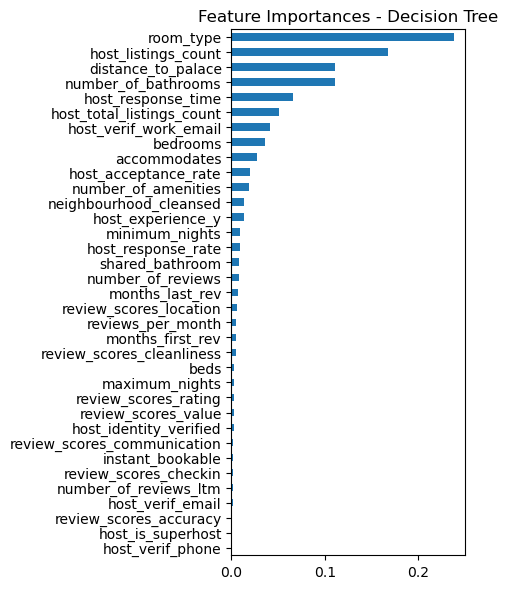

In [15]:
importances_dt = (pd.Series(mdl_dt.feature_importances_,
                            index=Xtr_transformed.columns,
                           ).sort_values(ascending=True))
fig, ax = plt.subplots(figsize=(5, 6))
ax = importances_dt.plot.barh()
ax.set_title("Feature Importances - Decision Tree")
ax.figure.tight_layout()

## Random Forest

In [16]:
mdl_rf = RandomForestRegressor(
    n_estimators=study_rf.best_params['n_estimators'],
    max_depth=study_rf.best_params['max_depth'],
    min_samples_split=study_rf.best_params['min_samples_split'],
    random_state=np.random.RandomState(777),
    min_samples_leaf=study_rf.best_params['min_samples_leaf'],
    n_jobs=-1,
)

pipeline = Pipeline(steps=[
            ('feature_engineering',
             FeatureEngineering(encode_hrt=study_rf.best_params['encode_hrt'])),
            ('type_detection', UpdateColumnTransformer(preprocessor1)),
            ('regressor', mdl_rf),
        ])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering', FeatureEngineering(encode_hrt=False)),
                ('type_detection',
                 UpdateColumnTransformer(preprocessor=ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        TargetEncoder())]),
                                                                                       ['host_response_time',
                                                                                        'neighbourhood_cleansed',
                                                                                        'room_type']),
                                                                                      ('tf',
                                                                                       Pipeline(steps=[('tf_to_binary',
                                                                                                        TFToBinary...
                                                                                        'review_scores_value',
                                                                                        'reviews_per_month',
                                                                                        'number_of_bathrooms',
                                                                                        'number_of_amenities',
                                                                                        'host_experience_y',
                                                                                        'months_first_rev',
                                                                                        'months_last_rev',
                                                                                        'distance_to_palace'])],
                                                                        verbose_feature_names_out=False))),
                ('regressor',
                 RandomForestRegressor(max_depth=43, min_samples_leaf=3,
                                       min_samples_split=5, n_estimators=388,
                                       n_jobs=-1,
                                       random_state=RandomState(MT19937) at 0x1D11B21D340))])

Reconstructing the transformed dataframe which served as the input to the final Regressor in the pipeline:

In [17]:
Xtr_transformed = pd.DataFrame(pipeline[:-1].transform(X_train),
                               columns=pipeline[-2].get_feature_names_out())

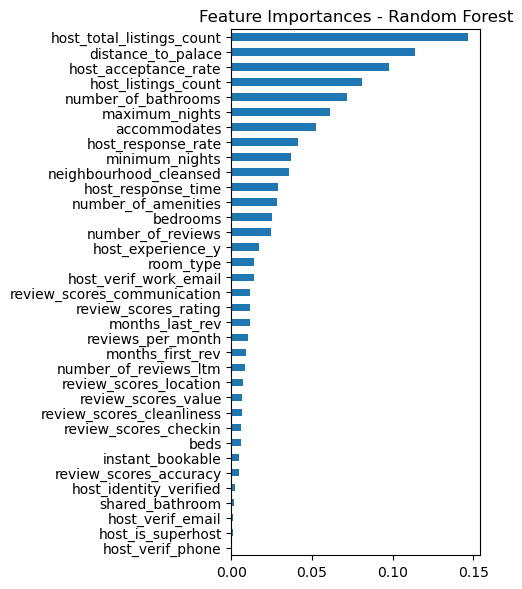

In [18]:
importances_rf = (pd.Series(mdl_rf.feature_importances_,
                            index=Xtr_transformed.columns,
                           ).sort_values(ascending=True))
fig, ax = plt.subplots(figsize=(5, 6))
ax = importances_rf.plot.barh()
ax.set_title("Feature Importances - Random Forest")
ax.figure.tight_layout()

## Extra Trees

In [19]:
mdl_et = ExtraTreesRegressor(
    n_estimators=study_et.best_params['n_estimators'],
    max_depth=study_et.best_params['max_depth'],
    min_samples_split=study_et.best_params['min_samples_split'],
    random_state=np.random.RandomState(777),
    min_samples_leaf=study_et.best_params['min_samples_leaf'],
    n_jobs=-1,
)
pipeline = Pipeline(steps=[
    ('feature_engineering',
     FeatureEngineering(encode_hrt=study_et.best_params['encode_hrt'])),
    ('type_detection', UpdateColumnTransformer(preprocessor2)),
    ('regressor', mdl_et),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering', FeatureEngineering(encode_hrt=False)),
                ('type_detection',
                 UpdateColumnTransformer(preprocessor=ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        TargetEncoder())]),
                                                                                       ['host_response_time',
                                                                                        'neighbourhood_cleansed',
                                                                                        'room_type']),
                                                                                      ('tf',
                                                                                       Pipeline(steps=[('tf_to_binary',
                                                                                                        TFToBinary...
                                                                                        'review_scores_value',
                                                                                        'reviews_per_month',
                                                                                        'number_of_bathrooms',
                                                                                        'number_of_amenities',
                                                                                        'host_experience_y',
                                                                                        'months_first_rev',
                                                                                        'months_last_rev',
                                                                                        'distance_to_palace'])],
                                                                        verbose_feature_names_out=False))),
                ('regressor',
                 ExtraTreesRegressor(max_depth=42, min_samples_leaf=3,
                                     min_samples_split=4, n_estimators=322,
                                     n_jobs=-1,
                                     random_state=RandomState(MT19937) at 0x1D11B21D240))])

Reconstructing the transformed dataframe which served as the input to the final Regressor in the pipeline:

In [20]:
Xtr_transformed = pd.DataFrame(pipeline[:-1].transform(X_train),
                               columns=pipeline[-2].get_feature_names_out())

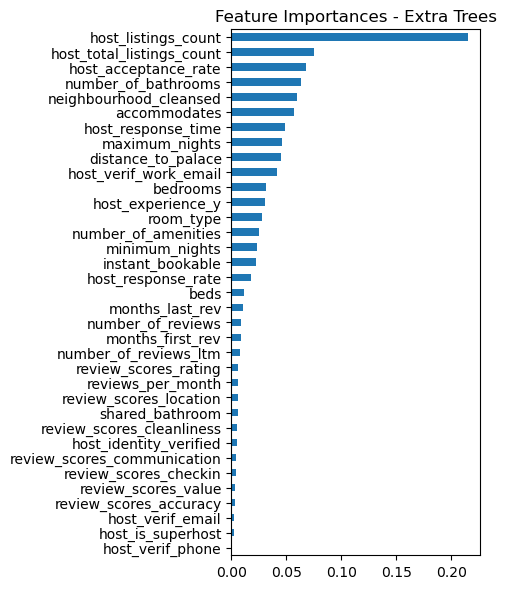

In [21]:
importances_et = (pd.Series(mdl_et.feature_importances_,
                            index=Xtr_transformed.columns,
                           ).sort_values(ascending=True))
fig, ax = plt.subplots(figsize=(5, 6))
ax = importances_et.plot.barh()
ax.set_title("Feature Importances - Extra Trees")
ax.figure.tight_layout()

## Comparative Feature Importances of Tree-Based Models

In this session, we explore the feature importances derived from various tree-based models — Decision Trees, Random Forests, and Extra Trees. To ensure clarity and relevance, we filtered out features with importances less than 0.05 across all models, focusing only on those that have a substantial impact. This approach allows us to prioritize key features for further analysis and future model refinement, thereby enhancing both interpretability and predictive accuracy.

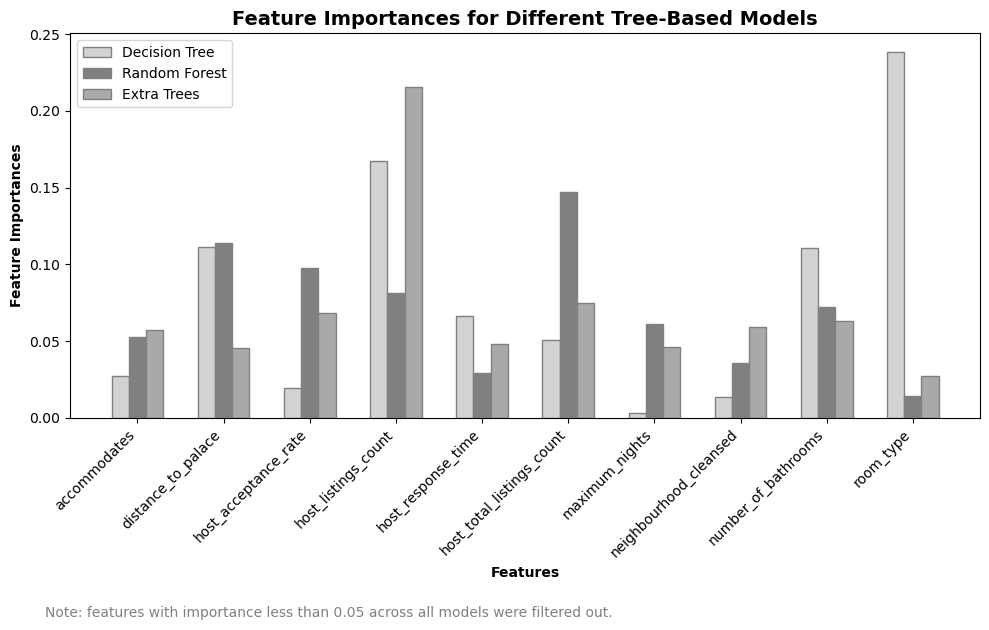

In [22]:
# Combine all Series into a DataFrame
df_features = pd.DataFrame({
    'Decision Tree': importances_dt,
    'Random Forest': importances_rf,
    'Extra Trees': importances_et
})

# Filter features with importance less than 0.05 across all models
df_features_filtered = df_features[(df_features >= 0.05).any(axis=1)]

# Extract feature names and importances
features = df_features_filtered.index
importances_dt = df_features_filtered['Decision Tree'].values
importances_rf = df_features_filtered['Random Forest'].values
importances_et = df_features_filtered['Extra Trees'].values

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Set width of bars
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting bars with shades of gray
ax.bar(r1, importances_dt, color='lightgrey', width=bar_width,
       edgecolor='grey', label='Decision Tree')
ax.bar(r2, importances_rf, color='grey', width=bar_width,
       edgecolor='grey', label='Random Forest')
ax.bar(r3, importances_et, color='darkgrey', width=bar_width,
       edgecolor='grey', label='Extra Trees')

# Adding labels, ticks, and title
ax.set_xlabel('Features', fontweight='bold')
ax.set_ylabel('Feature Importances', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(features))])
# Rotate and align x-axis labels
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_title('Feature Importances for Different Tree-Based Models',
             fontsize=14, fontweight='bold')

# Adding legend
ax.legend()

# Add note about filtered features
fig.text(0.05, -0.03, ('Note: features with importance less than 0.05'
                       + ' across all models were filtered out.'),
         va='center', fontsize=10, color='grey')

# Show plot
plt.tight_layout()
plt.show()